# PROYECTO 2023

Descripción proyecto

## Importar librerías

In [ ]:
%pip install numpy --upgrade
%pip install mahotas

In [97]:
# General
import numpy as np
import math
import os

# Procesamiento de imagenes
import cv2

# Visualizacion
from   tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Extraccion/seleccion de caracteristicas, clasificacion, evaluacion
from   balu3.fx.geo    import fourierdes, hugeo, flusser, gupta,basicgeo # caracteristicas geometricas?
from   balu3.fx.chr    import lbp, haralick, gabor
from   balu3.ft.norm   import minmax
from   balu3.fs.sel    import jfisher,sfs,clean, exsearch
from   balu3.io.misc   import imageload
from   balu3.cl.basics import ClassifierKNN
from   balu3.ft.trans  import pca
from scipy.stats import mode
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from skimage.measure import moments
from skimage.feature import graycomatrix, daisy, graycoprops, hog
from skimage.transform import warp_polar
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, RFE, RFECV, mutual_info_classif, chi2, f_classif
from sklearn.cross_decomposition import PLSRegression 

from pyfeats import fdta, lte_measures

from mlxtend.feature_selection import SequentialFeatureSelector as mlxsfs
from mahotas.features import zernike_moments

### Parámetros Extracción

In [161]:
IMG_WIDTH = IMG_HEIGHT = 800 // 1.2
# IMG_HEIGHT = (800 // 1.2)
# IMG_WIDTH = 380

# LBP
LBP_HDIV = 8
LBP_VDIV = 8
LBP_BINS = 59

# Haralick
HAR_DISTANCES = [1, 3, 5, 7, 9]
HAR_SIZE = 24 * len(HAR_DISTANCES)

# Gabor
GAB_ROTATIONS = 8
GAB_DILATATIONS = 8

# HOG
HOG_ORIENTATIONS = 9

# Zernike
ZER_RADIUS = 30
ZER_DEGREE = 8
ZER_SIZE = 25

# GLCM
GLCM_DISTANCES = 1
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GLCM_LEVELS = 4

GLCM_SIZE = GLCM_LEVELS

# Daisy
DAISY_RINGS = 3
DAISY_STEP = 100
DAISY_RADIUS = 35
DAISY_ORIENTATIONS = 8
DAISY_HISTOGRAMS = 8
DAISY_P = math.floor((IMG_WIDTH - DAISY_RADIUS * 2) / DAISY_STEP) 
DAISY_Q = math.floor((IMG_HEIGHT - DAISY_RADIUS * 2) / DAISY_STEP)
DAISY_R = (DAISY_RINGS * DAISY_HISTOGRAMS + 1) * DAISY_ORIENTATIONS

# Fetaures
features_per_function = {
    "lbp": LBP_HDIV * LBP_VDIV * LBP_BINS,
    "haralick": HAR_SIZE,
    "gabor": GAB_ROTATIONS * GAB_DILATATIONS + 3,
    "hog": 8100,
    "zernike": ZER_SIZE,
    "glcm": GLCM_SIZE,
    "daisy": DAISY_P * DAISY_Q * DAISY_R,
    "lte": 6,
}
print(features_per_function)

{'lbp': 3776, 'haralick': 120, 'gabor': 67, 'hog': 8100, 'zernike': 25, 'glcm': 4, 'daisy': 5000, 'lte': 6}


### Parámetros Selección

In [24]:
# SFS
N_SFS = 100

# Exhaustive
N_EX = 5

# RFECV
RFECV_STEP = 1
RFECV_CV = 5

# SBS
N_SBS = 100
SBS_VERBOSE = 2
SBS_CV = 100

# PCA
N_PCA = 100

# ICA
N_ICA = 100
ICA_RANDOM_STATE = 0

# PLSR
N_PLSR = 100

### Funciones auxiliares

In [156]:


def transform_to_polar(img):
    size = img.shape[0]
    new_size = int(size // 1.2)
    img = img[size - new_size: new_size, size - new_size: new_size]
    value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))

    polar_image = cv2.linearPolar(
        img, (img.shape[0]/2, img.shape[1]/2), value, cv2.WARP_FILL_OUTLIERS)

    polar_image = polar_image[:, :380]

    return polar_image


def skimage_polar(img):
    size = img.shape[0]
    new_size = int(size // 1.2)
    img = img[size - new_size: new_size, size - new_size: new_size]
    value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))

    polar_image = warp_polar(
        img, radius=value, output_shape=(400, 200), channel_axis=-1)

    polar_image = polar_image[:, :140]

    return polar_image


def extract_features(color_mode, dataset_type, feature_type):
    # Cargar rutas de imágenes y etiquetas según el dataset_type
    # ...
    K = 90   # <= NUMERO DE CLASES

    if dataset_type == 'train':
        fpath = "G00"     # <= DIRERCTORIO DE LA BASE DE DATOS
        N = 12   # <= NUMERO DE IMAGENES POR CLASE
        n = range(12)

    elif dataset_type == 'test':
        fpath = "G01"     # <= DIRERCTORIO DE LA BASE DE DATOS
        N = 4   # <= NUMERO DE IMAGENES POR CLASE
        n = range(12, 16)

    elif dataset_type == 'test2':
        fpath = "G02"     # <= DIRERCTORIO DE LA BASE DE DATOS
        N = 4   # <= NUMERO DE IMAGENES POR CLASE
        n = range(16, 20)

    dig_clase = 3     # <= NÚMERO DE DÍGITOS POR CLASE
    dig_img = 3     # <= NÚMERO DE DÍGITOS POR NÚMERO DE IMAGEN
    prefix = "ID"     # <= PREFIJO DEL NOMBRE DEL ARCHIVO DE LA IMAGEN
    imprefix = fpath + '/' + prefix

    # ground truth (clasificacion ideal)
    y = np.zeros((K*N), 'int')
    features = np.zeros((K*N, features_per_function[feature_type]))

    t = 0
    for j in tqdm(range(K)):                  # para cada clase
        for i in n:                # para cada imagen de la clase
            # Lectura de la imagen
            clase = j+1
            num_img = i+1
            img = imageload(imprefix, clase, dig_clase, num_img, dig_img)
            size = img.shape[0]
            new_size = int(size // 1.2)
            img = img[size-new_size: new_size,
                      size-new_size: new_size]
            y[t] = j+1

            # Preprocesar las imágenes según el color_mode (blue, red, green, blue)
            if color_mode == 'gray':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            elif color_mode == 'red':
                img = img[:, :, 0]
            elif color_mode == 'green':
                img = img[:, :, 1]
            elif color_mode == 'blue':
                img = img[:, :, 2]
            else:
                raise ValueError(f"Invalid color mode: {color_mode}")

            # Extraer características según el feature_type
            if feature_type == 'lbp':
                # Aplicar LBP a cada imagen
                features[t,:] = lbp(img, hdiv=LBP_HDIV, vdiv=LBP_VDIV)

            elif feature_type == 'haralick':
                # Aplicar características de textura Haralick a cada imagen
                # Implementa tu propia función para la extracción de características Haralick
                feats_har = None
                for i in HAR_DISTANCES:
                    if feats_har is None:
                        feats_har = haralick(img, distance=i,)
                    else:
                        feats_har = np.concatenate(
                            (feats_har, haralick(img, distance=i,)))
                features[t,:] = feats_har

            elif feature_type == 'hog':
                # Aplicar HOG a cada imagen

                features[t,:] = hog(img, orientations=HOG_ORIENTATIONS, pixels_per_cell=(
                    32, 32), cells_per_block=(2, 2))
            elif feature_type == 'daisy':
                features[t,:] = daisy(img, step=DAISY_STEP, radius=DAISY_RADIUS, rings=DAISY_RINGS,
                                       histograms=DAISY_HISTOGRAMS, orientations=DAISY_ORIENTATIONS).flatten()

            elif feature_type == 'lte':
                features[t,:], _ = lte_measures(img, None)

            else:
                raise ValueError(f"Invalid feature_type: {feature_type}")


            t = t+1
    # Devolver las características extraídas y las etiquetas
    return features, y


def select_features(xtrain, ytrain, algorithm):
    # SELECCIÓN:
    if algorithm == 'SFS':
        # SFS: Sequential Feature Selection
        selector = sfs(xtrain, ytrain, n_features=N_SFS, show=True)

        return selector

    elif algorithm == 'RFE':
        # RFE
        estimator = SVC(kernel='linear')
        selector = RFE(estimator)
        selector = selector.fit(xtrain, ytrain)
        selector = np.nonzero(selector.support_)[0]

        return selector

    # TRANSFORMACIÓN:
    elif algorithm == 'PCA':
        # PCA: Principal Component Analysis
        # Xtrain_sel, _, A, Xm, _  = pca(xtrain, n_components=1000)
        pca_selector = PCA(n_components=300)
        pca_selector.fit(xtrain)
        return pca_selector

    elif algorithm == 'ICA':
        # ICA: Independent Component Analysis
        selector = FastICA(n_components=150, random_state=ICA_RANDOM_STATE)
        selector.fit(xtrain, ytrain)
        Xtrain_sel = selector.transform(xtrain)

        return selector
    else:
        raise ValueError(f"Invalid algorithm: {algorithm}")


def selection_03(Xtrain, ytrain):
    '''
        clean-->Norm-->RFE---+-->SFS-->OUT
    '''
    ### Clean ###
    sclean = clean(Xtrain)
    Xtrain_clean = Xtrain[:, sclean]
    #Xtest_clean = Xtest[:,sclean]

    ### Normalización ###
    Xtrain_norm, a, b = minmax(Xtrain_clean)
    #Xtest_norm = Xtest_clean * a + b

    ### RFE ###
    #selector_rfe = select_features(Xtrain_norm, ytrain, 'RFE')
    #Xtrain_rfe = Xtrain_norm[:,selector_rfe]
    ### SFS 1 ###
    selector_sfs = select_features(Xtrain_norm, ytrain, 'SFS')
    return selector_sfs


def selection_04(Xtrain, ytrain):
    '''
        clean-->Norm-->PCA(95%)-->OUT
    '''

    ### Clean ###
    sclean = clean(Xtrain)
    Xtrain_clean = Xtrain[:, sclean]

    ### Normalización ###
    Xtrain_norm, a, b = minmax(Xtrain_clean)

    return Xtrain_norm


def load_classifier(classifier):
    if classifier == 'knn':
        return KNeighborsClassifier()
    elif classifier == 'lda':
        return LinearDiscriminantAnalysis()
    elif classifier == 'qda':
        return QuadraticDiscriminantAnalysis()
    elif classifier == 'árboles de decisión':
        return DecisionTreeClassifier()
    elif classifier == 'random forest':
        return RandomForestClassifier()
    elif classifier == 'svm lineal':
        return SVC(kernel='linear')
    elif classifier == 'svm rbf':
        return SVC(kernel='rbf')
    elif classifier == 'redes neuronales':
        return MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
    else:
        raise ValueError(f"Invalid classifier: {classifier}")


### Cargar imagenes

In [ ]:
!wget https://www.dropbox.com/s/s4opefjionbdbab/G00.zip
!unzip -qq G00.zip

In [ ]:
!wget https://www.dropbox.com/s/zur2wxzcce4qlgf/G01.zip
!unzip -qq G01.zip

## Extracción y selección de caracteristicas

In [142]:
def extraction_main(extraction_models, color_modes, image_set):
    # Create the "features" folder if it doesn't exist
    if not os.path.exists("features"):
        os.makedirs("features")
    if not os.path.exists("y"):
        os.makedirs("y")

    # Iterate over extraction models and color modes
    for model in tqdm(extraction_models):
        for color_mode in color_modes:
            # Extract features
            (X, y) = extract_features(color_mode, image_set, model)

            # Save features to files
            filename = f"features/X_{image_set}_{model}_{color_mode}.npy"
            y_filename = f"y/y_{image_set}.npy"

            np.save(filename, X)
            np.save(y_filename, y)
        
def select_main(caract_modes, color_modes):

    # Create the "selected_features" folder if it doesn't exist
    if not os.path.exists("selected_features"):
        os.makedirs("selected_features")

    y_train = np.load('y/y_train.npy')

    for color_mode in color_modes:
        X_train_color = []

        for caract in caract_modes:
            X_train_caract = np.load(f'features/X_train_{caract}_{color_mode}.npy')

            X_train_color.append(X_train_caract)

        X_train_color = np.concatenate(X_train_color, axis=1) # concatena todas las características de un mismo color

        print(f'Start feature selection for {color_mode}')

        selector = selection_03(X_train_color, y_train)

        np.save(f'selected_features/selector_{color_mode}.npy', selector)

        print(f'Selector saved for {color_mode}')

    print('Feature selection completed.')

## Clasificación

### De acá en adelante se pueden ejecutar los modelos 1 y 2 

### Ensamble de clasificadores

In [6]:
def majority_voting_ensemble(models, X_test):
    predictions = np.array([model.predict(X_test) for model in models])
    majority_vote = mode(predictions, axis=0)
    return majority_vote.mode.flatten()

## MODELO 1

descripción del modelo

In [7]:
def modelo_1(X_train, y_train):

    models = [load_classifier('knn')]
          
    # Dividir el conjunto de entrenamiento en entrenamiento y prueba (Hold Out)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, y_train, test_size=4, random_state=42)
    
    best_model = None
    best_accuracy = -1

    # Iterar sobre diferentes modelos y encontrar el que maximice la precisión
    for model in models:
        # Entrenar el modelo con el conjunto de entrenamiento
        model.fit(X_train_1, y_train_1)

        # Predecir las etiquetas para el conjunto de prueba
        y_pred = model.predict(X_test_1)

        # Calcular la precisión del modelo
        accuracy = accuracy_score(y_test_1, y_pred)

        # Actualizar el mejor modelo si se encuentra uno con una precisión mayor
        model.fit(X_train, y_train)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    
    # Entregar el mejor modelo encontrado
    entregable_modelo_1 = best_model

    return models, entregable_modelo_1

## MODELO 2

descripción del modelo

In [8]:
def model_2(X_train, y_train):
    models = [load_classifier('lda')]
    
    best_model = None
    best_accuracy = 0.0
    # Iterar sobre diferentes modelos y encontrar el que maximice la precisión en cross-val
    for model in models:
        # Realizar cross-val con 4 folds en las imágenes de grupo 0
        scores = cross_val_score(model, X_train, y_train, cv=4)

        # Calcular la precisión promedio en cross-val
        accuracy = scores.mean()

        # Actualizar el mejor modelo si se encuentra uno con una precisión mayor
        model.fit(X_train, y_train)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

    # Entregar el mejor modelo encontrado
    entregable_modelo_2 = best_model

    return models, entregable_modelo_2

## MODELO 3

In [9]:
def model_3(X, y):

    models = [load_classifier('lda')]
    
    best_model = None
    best_accuracy = 0.0

    n_folds = 5
    skf = StratifiedKFold(n_splits=n_folds)

    for model in models:
      accuracies = np.array([])
      for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train_3, X_test_3 = X[train_index], X[test_index]
            y_train_3, y_test_3 = y[train_index], y[test_index]

            model.fit(X_train_3, y_train_3)

            y_pred = model.predict(X_test_3)

            accuracy = accuracy_score(y_test_3, y_pred)
            
            accuracies = np.append(accuracies, accuracy)
      mean_accuracy = np.mean(accuracies)

      if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_model = model

      best_model.fit(X, y)

    return models, best_model

## Código para ejecutar tests

Insertar link en la celda de abajo y ejecutar

In [ ]:
!wget <url>
!unzip -qq G02.zip

Si no está cargado el G01.zip

In [ ]:
!wget https://www.dropbox.com/s/zur2wxzcce4qlgf/G01.zip
!unzip -qq G01.zip

Cargar selected_features, selection_steps e y_train

In [ ]:
!wget https://www.dropbox.com/s/f22yzeacl2y2wbn/selected_features.zip
!wget https://www.dropbox.com/s/1fngntbr9bdpy1s/selection01_steps.zip
!wget https://www.dropbox.com/s/vk56ogri85txlpt/y.zip

!unzip -qq selected_features.zip
!unzip -qq selection01_steps.zip
!unzip -qq y.zip

Ejecutar celda de abajo para probar, cambiar TEST por "test" o "test2", siendo G01 Y G02 respectivamente.

In [162]:
TEST = "test"
EXTRACTION_MODS = ['haralick']
COLOR_MODES = ["gray", "red"]

def test_set(test_set):

    # MODO DE EJECUCION
    
    extraction_main(EXTRACTION_MODS, COLOR_MODES, "train") #descomentar para train y test
    extraction_main(EXTRACTION_MODS, COLOR_MODES, test_set) #descomentar para train y test
    # select_main(EXTRACTION_MODS, COLOR_MODES) #descomentar para train

    # return # descomentar para train
    y_train = np.load('y/y_train.npy')
    y_test = np.load(f'y/y_{test_set}.npy')

    X_train_final = []
    X_test_final = []
    
    for color in COLOR_MODES:
        X_train = []
        X_test = []
        
        for ext in EXTRACTION_MODS:
            X_train.append( np.load(f'features/X_train_{ext}_{color}.npy') )
            X_test.append( np.load(f'features/X_{test_set}_{ext}_{color}.npy') )
        # selector = np.load(f'selected_features/selector_{color}.npy')



        X_train = np.concatenate(X_train, axis=1)
        X_test = np.concatenate(X_test, axis=1)

        sclean = clean(X_train)
        X_train_clean = X_train[:,sclean]
        X_test_clean = X_test[:,sclean]

        X_train_norm, a, b = minmax(X_train_clean)
        X_test_norm = X_test_clean * a + b

        # X_train = X_train_norm[:,selector]
        # X_test = X_test_norm[:,selector]
        # pca_selector = select_features(X_train_norm, y_train, 'PCA')
        # X_train_pca  = pca_selector.transform(X_train_norm)
        # X_test_pca = pca_selector.transform(X_test_norm)
         
        # ica_selector = select_features(X_train_norm, y_train, 'ICA')
        # X_train_ica = ica_selector.transform(X_train_norm)
        # X_test_ica = ica_selector.transform(X_test_norm)

        X_train_final.append(X_train_norm)
        X_test_final.append(X_test_norm)

    X_train = np.concatenate(X_train_final, axis=1)
    X_test = np.concatenate(X_test_final, axis=1)


    ##MODELO 1
    models, best_model_1 = modelo_1(X_train, y_train)
    y_pred_1 = best_model_1.predict(X_test)
    accuracy_m1 = accuracy_score(y_test, y_pred_1)
    
    print(f"Accuracy model 1: {accuracy_m1}")

    ## MODELO 2
    models, best_model_2 = model_2(X_train, y_train)
    y_pred_2 = best_model_2.predict(X_test)
    accuracy_m2 = accuracy_score(y_test, y_pred_2)

    print(f"Accuracy model 2: {accuracy_m2}")
    
    ## MODELO 3
    models, best_model_3 = model_3(X_train, y_train)
    y_pred_3 = best_model_3.predict(X_test)
    accuracy_m3 = accuracy_score(y_test, y_pred_3)

    print(f"Accuracy model 3: {accuracy_m3}")
    


test_set(TEST)



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

KeyboardInterrupt: 

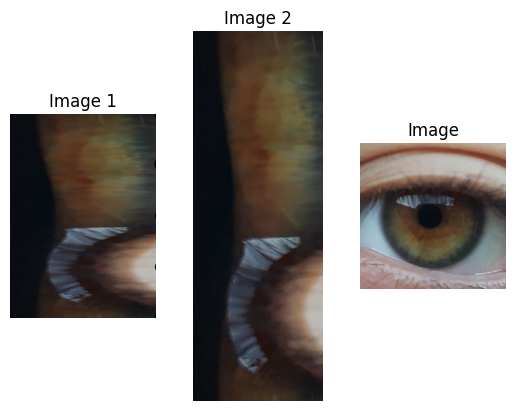

In [110]:
from skimage.transform import warp_polar

def transform_to_polar(img):
    size = img.shape[0]
    new_size = int(size // 1.2)
    img = img[size - new_size: new_size, size - new_size: new_size]
    value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))

    polar_image = cv2.linearPolar(
        img, (img.shape[0]/2, img.shape[1]/2), value, cv2.WARP_FILL_OUTLIERS)

    polar_image = polar_image[:, :380]

    return polar_image

def skimage_polar(img):
    size = img.shape[0]
    new_size = int(size // 1.2)
    img = img[size - new_size: new_size, size - new_size: new_size]
    value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))

    polar_image = warp_polar(img, radius=value, output_shape=(400, 200), channel_axis=-1)
    
    polar_image = polar_image[:, :140]

    return polar_image

img = plt.imread('G01\ID054_016.png')

polar = transform_to_polar(img)
polar2 = skimage_polar(img)

# Plot both images

fig, axes = plt.subplots(1, 3)

# Display the first image in the first subplot
axes[0].imshow(polar)
axes[0].set_title("Image 1")

# Display the second image in the second subplot
axes[1].imshow(polar2)
axes[1].set_title("Image 2")

# Display the second image in the second subplot
axes[2].imshow(img)
axes[2].set_title("Image")

# Remove the axis ticks and labels for a cleaner look
for ax in axes:
    ax.axis("off")

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the plot
plt.show()
